# **Projet de Processus de Poisson :** Thinning Algorithms for Simulating Point Processes

La méthode du **thinning** permet de simplifier la représentation spatiale de données en sélectionnant certains points vérifiant une condition donnée, tout en préservant les caractéristiques importantes de ces données. C'est une généralisation de la méthode d'acceptation/rejet souvent utilisée pour générer des variables aléatoires. La méthode du thinning permet de créer un processus de Poisson non homogène en sélectionnant judicieusement des points à partir d'un processus de Poisson homogène.

In [1]:
#! pip install -U Cython numpy
#! pip install hawkeslib

In [705]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import math
import pandas as pd
from scipy.stats import kstest
import statsmodels.api as sm
from hawkeslib import UnivariateExpHawkesProcess as UVHP
from datetime import datetime

## **Processus de comptage et processus ponctuel**

Pour commencer, nous définissons dans cette partie les processus de comptage et les processus ponctuels. En effet, ces deux derniers sont utilisés pour définir les processus de Poissons et de Hawkes, qui nous intéressent dans ce projet.

**Définition:** Le processus N(t) de comptage compte le nombre d'événements qui arrivent dans l'intervalle de temps $[0,t]$. Il  est défini par le processus $\{N(t) ; t \geq 0\}$ et vérifie les propriétés suivantes : 
- $\forall t \geq 0$, $N(t)$ est constant par morceaux et à valeurs dans $\mathbb{N}$ ;
- $t \mapsto N(t) \text{ est croissante}$ ;
- $\forall 0<a<b$, $N(b)-N(a)$ représente le nombre d'événements arrivant dans l'intervalle de temps $]a,b]$.


**Définition:** Un processus ponctuel sur $\mathbb{R}^+$ est un sous-ensemble aléatoire et dénombrable de $\mathbb{R}^+$ où chaque point correspond au moment d'occurance d'événement. Il est aussi défini comme l'intersection entre $\mathbb{R}^+$ et la séquence croissante des temps auxquels les événements se produisent. Cette séquence est aussi appelée comme l'ensemble des temps d'arrivée et notée $0 < T_1 < T_2 < ... < T_n < ...$ avec  $(T_n)_n \in \mathbb{R}^+$ 

**Lien entre processus ponctuel $(T_n)_n$ et processus de comptage $(N_t)_t$:**   
$ \forall n \in \mathbb{N}^+$ et pour tout ($t_1$, $t_2$, ..., $t_n$) dans $\mathbb{R}^+$ : 

$ \{T_1 \leq t_1, T_2 \leq t_2, \ldots, T_n \leq t_n \} = \{ N_{t_1} \geq 1, N_{t_2} \geq 2, \ldots, N_{t_n} \geq n \}$

Il est donc équivalent de définir un processus ponctuel grâce aux temps d'arrivée ou grâce au processus de comptage. On choisira pour la suite de le définir avec $(N_t)_t$.

***Propriété :*** Un processus de ponctuel N est à *accroissements indépendants* si le nombre de points entre intervalles disjoints est indépendant. Autrement dit, $\forall n \in \mathbb{N}^*$, $\forall \quad  0<t_1<t_2<...<t_n$, les variables aléatoires $N_{t_1}-N_0, N_{t_2}-N_{t_1}, ..., N_{t_n}-N_{t_{n-1}}$ sont indépendantes.



***Propriété:*** Un processus ponctuel est à *accroissements stationnaires* si la distribution du nombre de points de tout intervalle de temps dépend uniquement de la longueur de cet intervalle. Autrement dit, $\forall s \geq 0$, le nombre de points dans l'intervalle $(t,s+t]$ soit $N_{t+s}-N_{t}$ a la même distribution $\forall t$.

## **Processus de poisson homogène sur $\mathbb{R}_+$**

Dans cette partie, nous donnons quelques définitions et propriétés des processus de Poisson homogènes avant de les simuler !

**Définition :** Un processus de ponctuel $\{N(t) ; t \geq 0\}$ est appelé processus de Poisson homogène d'intensité $\lambda > 0$ si :
- $N(0) = 0$ ; 
- Le processus est à accroissements indépendants et stationnaires;
- $\mathbb{P}(N_{t+h} - N_t = 1) = \lambda h + o(h)$;
- $\mathbb{P}(N_{t+h} - N_t > 1) = o(h)$.

***Proposition:*** Le nombre de points dans un intervalle de longueur t d'un processus de poisson homogène suit une loi de Poisson de paramètre $\lambda t$. 
$$ \mathbb{P}\{N(t + s) - N(s) = n \} = e^{-\lambda t}\frac{{(\lambda t)^n }}{{n!}}$$

***Proposition:*** Les temps d'arrivée d'un processus de poisson homogène sont distribués suivant une variable aléatoire qui suit une loi exponentielle de paramètre $\lambda$.

***Proposition:***  $\mathbb{E}(N_t)=Var(N_t)= \lambda t$

### *Algo 1: Simulation d'un processus de Poisson Homogène avec un taux λ sur [0,T]*

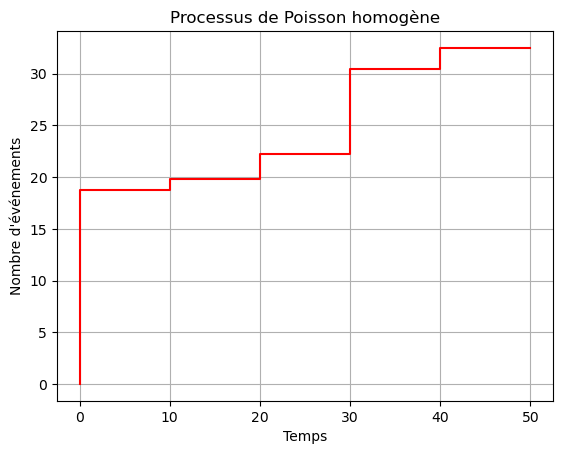

In [3]:
def Process_homogène(lamb,T):
    val=[0]
    t=0
    while True :
        u=npr.uniform(0,1)
        w=-1/lamb * np.log(u)## w~exp(lamb)
        #print(w)
        t=t+w
        #print(times)
        if t > T : 
            return val, len(val)
        else : 
            val.append(t)

#On simule un Poisson Homogène avec notre "Algo 1"
lamb = 0.1
T = 50
P,n= Process_homogène(lamb,T)

times=np.linspace(0,T,n) #création intervalle de temps

#Affichage
plt.step(times, P,color='red')
plt.xlabel('Temps')
plt.ylabel('Nombre d\'événements')
plt.title('Processus de Poisson homogène')
plt.grid(True)
plt.show()

## **Processus de poisson inhomogène sur $\mathbb{R}_+$**

Dans cette partie, nous définissions désormais les processus de poisson inhomogène avant d'également les simuler !

**Définition :** Un processus de ponctuel $\{N(t) ; t \geq 0\}$ est appelé processus de Poisson inhomogène avec pour intensité la fonction localement intégrable $\lambda (t) > 0$, $t>0$ si :
- $N(0) = 0$ ; 
- Le processus est à accroissements indépendants et stationnaires;
- $\mathbb{P}(N_{t+h} - N_t = 1) = \lambda(t) h + o(h)$;
- $\mathbb{P}(N_{t+h} - N_t > 1) = o(h)$.

La fonction $\Lambda$ : $t \mapsto \int_{0}^{t} \lambda (s) \,ds $ est appelée l'intensité cumulée du processus de Poisson inhomogène. 

La définition précédente est identique à celle d'un processus de Poisson homogène à la différence que l'intensité n'est maintenant plus constante, mais dépend du temps $t$.

***Proposition :*** Un processus de Poisson inhomogène N d'intensité la fonction $\lambda (t)$ suit une loi de Poisson de paramètre $\int_{0}^{t}\lambda (s) \,ds$ : 

$$\mathbb{P}(N(t)=n) = \frac{\exp^{-\int_{0}^{t}\lambda (s) \,ds} (\int_{0}^{t}\lambda (s) \,ds)^n} {n!} $$

***Proposition:***  $\mathbb{E}(N_t)=Var(N_t)=\Lambda(t)$

### *Algo 2: Simulation d'un processus de Poisson Inhomogène avec une fonction intensité bornée sur [0,T]*

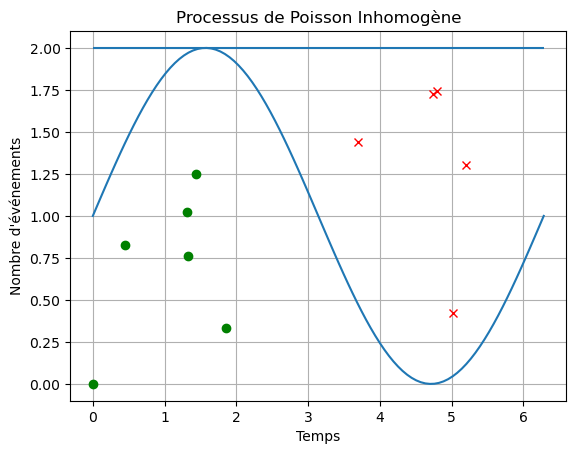

In [4]:
lamb = 0.4
Tmax = 2*np.pi
times=np.linspace(0,Tmax, 10)

#### fonction densité ####
def lambd(t) :
    return 1+np.sin(t)

#### fonction qui calcule le sup ####
def sup(fonction, debut=0, fin=Tmax, pas=0.01):
    t = debut
    sup = fonction(debut)
    while t <= fin: 
        if fonction(t) > sup:
            sup = fonction(t)
        t += pas
    return sup

 
#### fonction qui génère le process ####
def Process_inhomogène(lamb,Tmax):
    T=[0] ; S=[0]
    T_R=[] ; R=[]
    t=0 ; s=0
    lamb_max= sup(lamb)
    
    while s<Tmax :
        u=npr.uniform(0,1)
        w=-math.log(u)/lamb_max    # w~exp(lamb_max)
        s=s+w
        D=npr.uniform(0,1)
        if D <= lamb(s)/lamb_max : #condition d'acception des temps tau par rapport au sup de notre fonction lambda 
            t=s
            T.append(t)            #tau accepté
            S.append(D*lamb_max)   #valeur de D*lamdba_max pour les tau acceptés
        else :
            T_R.append(s)                                                                                                                                       #Lise refusée
            R.append(D*lamb_max)   #valeur de D*lamdba_max pour les tau refusés
            t=s                    #pour bien s'assurer qu'on ne dépasse pas tmax même dans ce cas où on incrément pas les tau acceptés 
    if t<=Tmax :
        return T,S,T_R,R
    else : 
        return T[:-1],S[:-1],T_R[:-1],R[:-1] #on renvoie tous les points sauf le dernier élémént qui est supérieur à Tmax
        
                                        
     
x=np.linspace(0,Tmax,100)
#Application de la fonction rate: 
plt.plot(x, lambd(x))
plt.hlines(2,0,Tmax)



#Applications de la fonction de simulation/thinning
T,D,T_R,R= Process_inhomogène(lambd,Tmax)

plt.plot(T,D, "o",color='green')
plt.plot(T_R,R, "x",color='red')
plt.xlabel('Temps')
plt.ylabel('Nombre d\'événements')
plt.title('Processus de Poisson Inhomogène')
plt.grid(True)
plt.show()

## **Processus de Hawkes sur $\mathbb{R}_+$**

**Définition :** Un processus est dit simple si 
$$ P(N({t}) = 0 \text{ ou } 1 \text{ pour tout } t) = 1 $$


**Définition** : (Hawkes, 1971) Un processus de Hawkes est un processus ponctuel univariant simple N(t) qui vérifie : 
- N(t) = 0 ;
- λ(t) est processus stochastique continu à gauche, donné par l'intégrale de Stieltjes :
$$ \lambda(t) = \mu + \int_{0}^{t} \alpha \exp(-\beta (t-s)) \, dN(s) = \mu + \sum_{k: t_k < t} \alpha \exp^{-\beta (t-s)} $$
avec $\mu>0$ et $0 < \alpha < \beta$ ;
- λ(t) est l'intensité stochastique du processus de ponctuel telle que :  
$$ P(N(t+h) - N(t) = 1 \,|\, \mathcal{F}_{t^-}^N) = \lambda(t)h + o(h) $$ 
- Le processus de ponctuel est ordonné tel que : 
$$ P(N(t+h) - N(t) \geq 2 \,|\, \mathcal{F}_{t^-}^N) = o(h) $$

Ce processus est dit Hawkes univariant avec une décroissance exponentielle sur $[0,\inf)$.




### Algo 3: Simulation of a Univariate Hawkes Poisson with Exponential Kernel

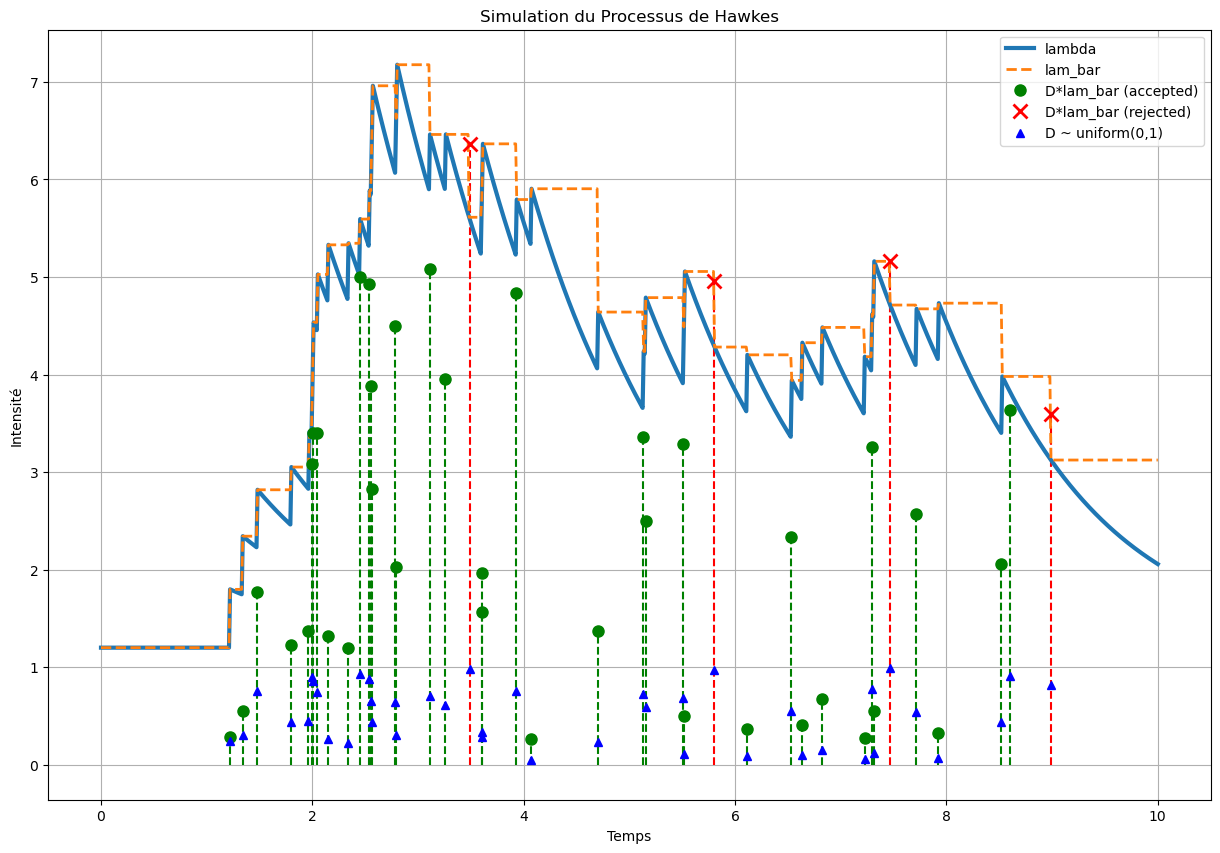

In [339]:
# fonction densité ####
def lam(su,times,mu=1.2,alpha=0.6,beta=0.8) :
    if times == []:
        return mu
    else : 
        return mu + np.sum(alpha * np.exp(-beta * (su - np.array(times))))    


def Hawkes_Process(mu, alpha, beta, Tmax):
    T = []  # Pour stocker les tau
    S = [] # Pour stocker le critère d'accepttaion du tau
    s = 0  # Initialize s
    T_R = [] ; R = []
    L = [] ; I = []
    while s < Tmax:
        if T == []:
            lambda_bar = mu
            L.append(lambda_bar)
        u = np.random.uniform(0, 1)
        w = -np.log(u)/lambda_bar
        s += w
        D = np.random.uniform(0, 1)
        I.append(D)
        l=lam(s,T)
        if D * lambda_bar <= l:
            t=s
            T.append(t)              #tau accepté
            S.append(D*lambda_bar)   #valeur de D*lamdba_max pour les tau acceptés
            lambda_bar= mu + alpha * np.sum(np.exp(-beta * (s - np.array(T))))
        else :
            T_R.append(s)                                                                                                                                       #Lise refusée
            R.append(D*lambda_bar)   #valeur de D*lamdba_max pour les tau refusés
            t=s                    #pour bien s'assurer qu'on ne dépasse pas tmax même dans ce cas où on incrément pas les tau acceptés
            lambda_bar= mu + alpha * np.sum(np.exp(-beta * (s - np.array(T))))
    plt.show()
    if t<=Tmax :
        return T,S,T_R,R,I
    else :
        return T[:-1],S[:-1],T_R[:-1],R[:-1], I[:-2] #on renvoie tous les points sauf le dernier élémént qui est supérieur à Tmax

# Application:
mu = 1.2
alpha = 0.6
beta = 0.8
Tmax = 10
TH,DH,TH_R,RH, D= Hawkes_Process(mu, alpha, beta, Tmax)

#Application de la fonction rate:
times=np.linspace(0,Tmax,1000)
l=[] ; sup_l = []; brk2 = []
j=0; count =0
for i in times:
    count +=1
    if j < len(TH)-1:
        if i < TH[0]:
            temp = mu
        elif i < TH[j]:
            temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:j]))))
        else :
            brk2.append(count-1)
            j=j+1
            temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:j]))))
        l.append(temp)
    else:
        temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:-1]))))
        l.append(temp)


        
#Affichage du lambda max
brk=[]
b=0
j=0
i=0

int_array = [int(x*100) for x in TH_R]
brk=brk2+int_array
brk=sorted(brk)

for j in range(len(brk)):
    while i < brk[j]:
        sup_l.append(max(l[b:brk[j]]))
        i+=1
    b=brk[j]
    j+=1
while i < len(l):
    sup_l.append(max(l[brk[-1]:len(l)-1]))
    i+=1


fig = plt.figure(figsize = (15, 10))


count=0
for i in TH:
    if count < len(DH):
        plt.plot([i, i], [0, DH[count]], 'g--')
        count+=1
    #plt.axvline(x=i, linestyle='--', color='green', linewidth=1)
count=0
for j in TH_R:
    if count < len(RH):
        plt.plot([j, j], [0, RH[count]], 'r--')
        count+=1
    #plt.axvline(x=j, linestyle='--', color='red', linewidth=1)

plt.plot(times, l,label="lambda", linewidth=3)
plt.plot(times, sup_l, linestyle='--', label="lam_bar",linewidth=2)

plt.plot(TH,DH, "o",color='green', markersize=8, label="D*lam_bar (accepted)")
plt.plot(TH_R,RH, "x",color='red', markersize=10, markeredgewidth=2, label="D*lam_bar (rejected)")
TH2=TH+TH_R
TH2=sorted(TH2)

plt.plot(TH2, D,"^",color='blue', markersize=6, label="D ~ uniform(0,1)")
plt.xlabel('Temps')
plt.ylabel('Intensité')
plt.title('Simulation du Processus de Hawkes')
plt.legend()
plt.grid(True)
plt.show()

## **Cas pratique : Application de l'algo de Hawkes aux données financières du CAC40**

In [449]:
#Chargement des données
CAC40_1an = pd.read_csv('^FCHI_1an.csv')
CAC40_2an = pd.read_csv('^FCHI_2ans.csv')
CAC40_5an = pd.read_csv('^FCHI_5ans.csv')
display(CAC40_1an)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-05-15,7443.379883,7455.629883,7397.859863,7418.209961,7418.209961,48638700
1,2023-05-16,7394.850098,7427.569824,7377.810059,7406.009766,7406.009766,61261800
2,2023-05-17,7378.830078,7422.580078,7354.540039,7399.439941,7399.439941,57783800
3,2023-05-18,7440.750000,7481.779785,7426.390137,7446.890137,7446.890137,59991600
4,2023-05-19,7469.779785,7523.560059,7463.959961,7491.959961,7491.959961,67973200
...,...,...,...,...,...,...,...
251,2024-05-08,8093.620117,8157.479980,8089.279785,8131.410156,8131.410156,53988400
252,2024-05-09,8123.919922,8191.919922,8114.879883,8187.649902,8187.649902,39071500
253,2024-05-10,8232.650391,8259.190430,8211.200195,8219.139648,8219.139648,57091000
254,2024-05-13,8211.070313,8223.809570,8186.770020,8209.280273,8209.280273,48113100


In [342]:
## regarder date d'ouverture marché et de fermeture 
## abs(close-open) / close > seuil (1%) #le rendement permet d'avoir une mesure à peu près homogène
## on compte le nombre de fois où ça arrive et a chaque fois que ca arrive on le stocke
## faire repartition dans le vecteur temps avec histogramme  et le vecteur est censé représenté une loi exponentielle

### Processus de Comptage

On regarde à la valeur de l'indice du CAC40 à l'ouverture et à la fermeture du marché. On réalise un calcul de rendement comme suit :  abs(close-open) / close et l'on veut savoir quand-est qu'il dépasse un seuil donné *(ici 0.5%)*.

Ensuite, on veut compter le nombre de fois où le redement dépasse ce seuil dans notre plage de temps et on stocke les temps de dépassement. Cela nous donne le processus de comptage ci-dessous :

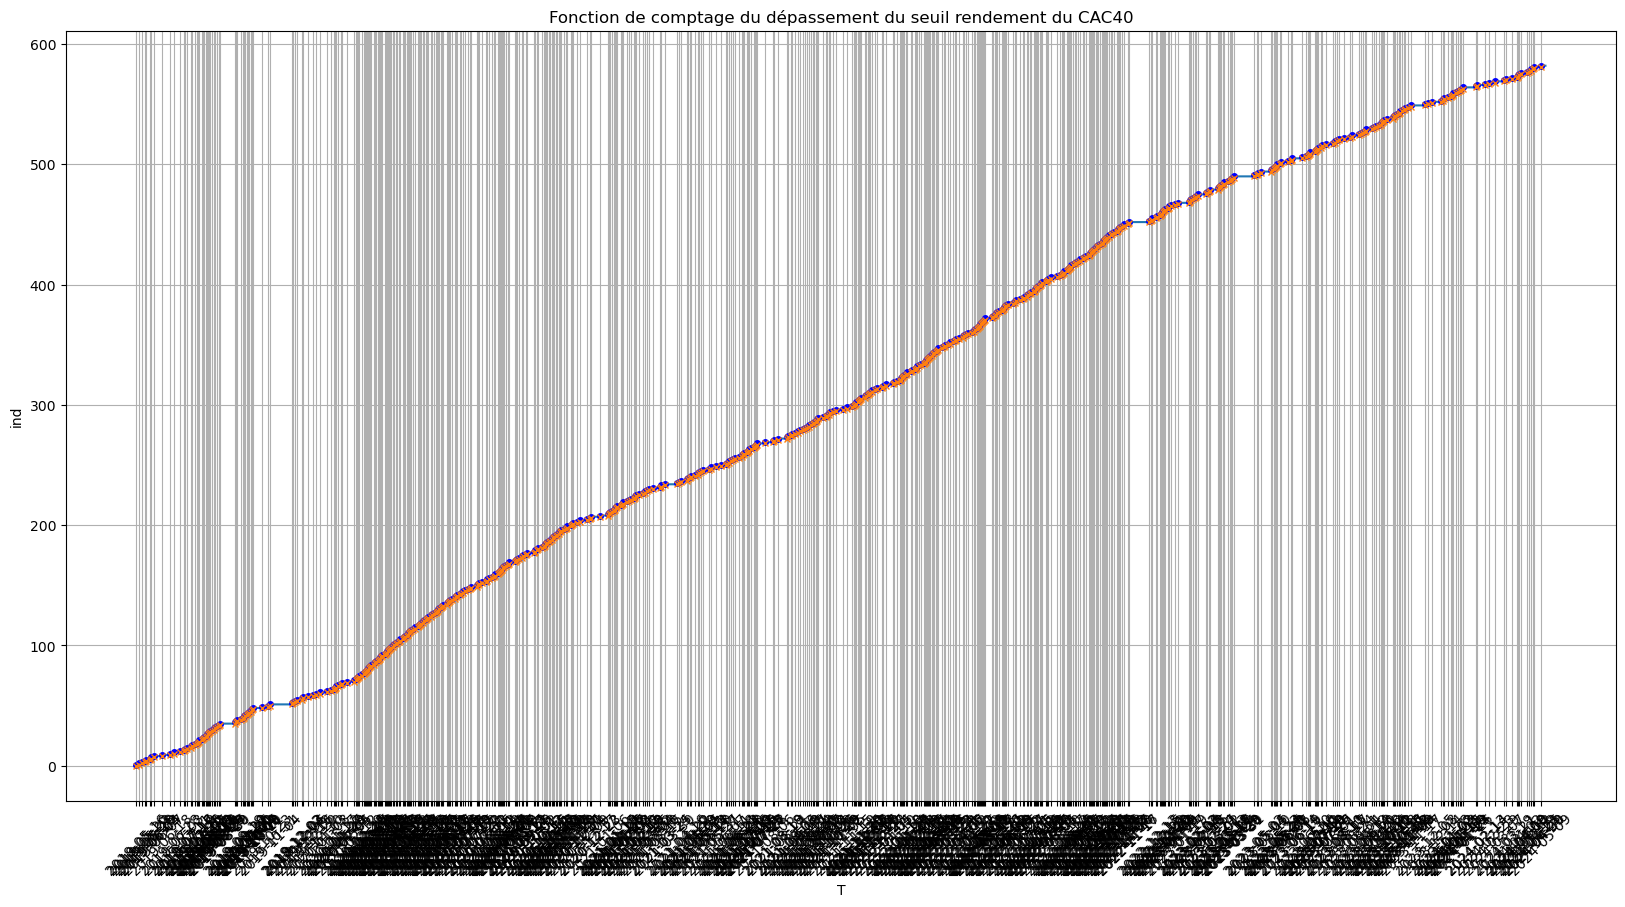

Temps de sauts 1 an: [0.0, 1.0, 3.0, 6.0, 7.0, 8.0, 10.0, 13.0, 22.0, 24.0]
---------------
Temps de sauts 2 ans: [0.0, 1.0, 5.0, 6.0, 7.0, 8.0, 13.0, 14.0, 15.0, 18.0]
---------------
Temps de sauts 5 ans: [0.0, 4.0, 7.0, 12.0, 13.0, 18.0, 19.0, 22.0, 33.0, 43.0]


In [648]:
# Fonction pour convertir une date en float
def date_to_float(date_str):
    # Conversion de la chaîne de caractères en objet datetime
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    # Conversion de la date en timestamp (secondes depuis l'époque Unix)
    timestamp = date_obj.timestamp()
    # Vous pouvez ensuite diviser par le nombre de secondes par jour si vous voulez un float en jours
    return (timestamp / (24 * 3600))

def compt(seuil,CAC40):
    #display(CAC40.iloc[:,1]) 2eme colonne 
    ferme = CAC40.iloc[:,4]
    ouvert = CAC40.iloc[:,1]
    date = CAC40.iloc[:,0]

    T=[]
    T_last=[]
    Val=[]
    ind_seuil=[]
    ind_1=[]; ind_2=[]
    ind=0
    a=0
    for i in range(len(CAC40)): 
        if np.abs(ferme[i] - ouvert[i]) / ferme[i] > seuil :
            T.append(date[i]) #à chaque fois que l'expression dépasse le seuil on stocke la date 
            Val.append(np.abs(ferme[i] - ouvert[i]) / ferme[i]) #on stocke également la valeur du taux
            ind+=1
            ind_seuil.append(ind) #on stocke l'index
            ind_1.append(ind)
            ind_2.append(ind-1)
        else :
            ind_seuil.append(ind)
    
    float_dates = [date_to_float(date) for date in T]
    init = float_dates[0]
    for i in range(len(float_dates)):
        float_dates[i] = float_dates[i] - init
    return date,T,ind_1,ind_2,ind_seuil,float_dates
        
days,T,ind_1,ind_2,ind_seuil,TH_1an=compt(seuil=0.005,CAC40=CAC40_1an)
days,T,ind_1,ind_2,ind_seuil,TH_2an=compt(seuil=0.005,CAC40=CAC40_2an)
days,T,ind_1,ind_2,ind_seuil,TH_5an=compt(seuil=0.005,CAC40=CAC40_5an)

# Filtrer les données
x_filtered = days[ind_1]

fig, ax = plt.subplots(figsize = (20, 10))
plt.plot(days, ind_seuil, drawstyle='steps-post')
plt.plot(T, ind_1, "o", color="blue", markersize=4)
plt.plot(T, ind_2, "x", markersize=4, label='T')
#print(T)
plt.xlabel('T')
ax.set_xticks(T)
ax.set_xticklabels(T, rotation=45)
plt.ylabel('ind')
plt.title('Fonction de comptage du dépassement du seuil rendement du CAC40')
plt.grid(True)
plt.show()

print("Temps de sauts 1 an:",TH_1an[0:10])
print("---------------")
print("Temps de sauts 2 ans:",TH_2an[0:10])
print("---------------")
print("Temps de sauts 5 ans:",TH_5an[0:10])

### **Hawkeslib** pour un Poisson Homogène

In [655]:
#ON simule un Poisson Homogène avec notre "Algo 1"
lamb = 0.1
T = 50
P,n= Process_homogène(lamb,T)

In [656]:
from hawkeslib import UnivariateExpHawkesProcess as UVHP
uv = UVHP()
uv.fit(np.array(P))

-17.753397404949105

In [657]:
# verify that the unconditional mean makes sense
mu, alpha, beta = uv.get_params()

N_approx = mu * P[-1] / (1 - alpha)

print(N_approx)
print(len(P))
print("alpha:",alpha)
print("mu:",mu)
print("beta:",beta)

6.002719289270735
6
alpha: 0.0022309490552517796
mu: 0.140764350137514
beta: 0.9132259020760958


**Interprétation :** 
- On remarque qu'alpha est tend vers 0 donc on a bien ce à quoi on s'attendait en passant un poisson homogène dans l'estimation des coefficient d'un Hawkes. En effet, les sauts d'intensité sont d'une taille alpha, ainsi si alpha tend vers 0 cela veut dire que les sauts à chaque évènements sont très petits donc les variations d'intesnité très faibles, ainsi on peut se ramener à un poisson homogène !

- De plus le paramètre mu tend bien vers notre lambda initial. Ce qui confirme qu'on a bie un processus de poisson homogène qui est retouvé par l'algorithme de recherche de coefficients d'hawkeslib.

### **Hawkeslib** pour un Hawkes

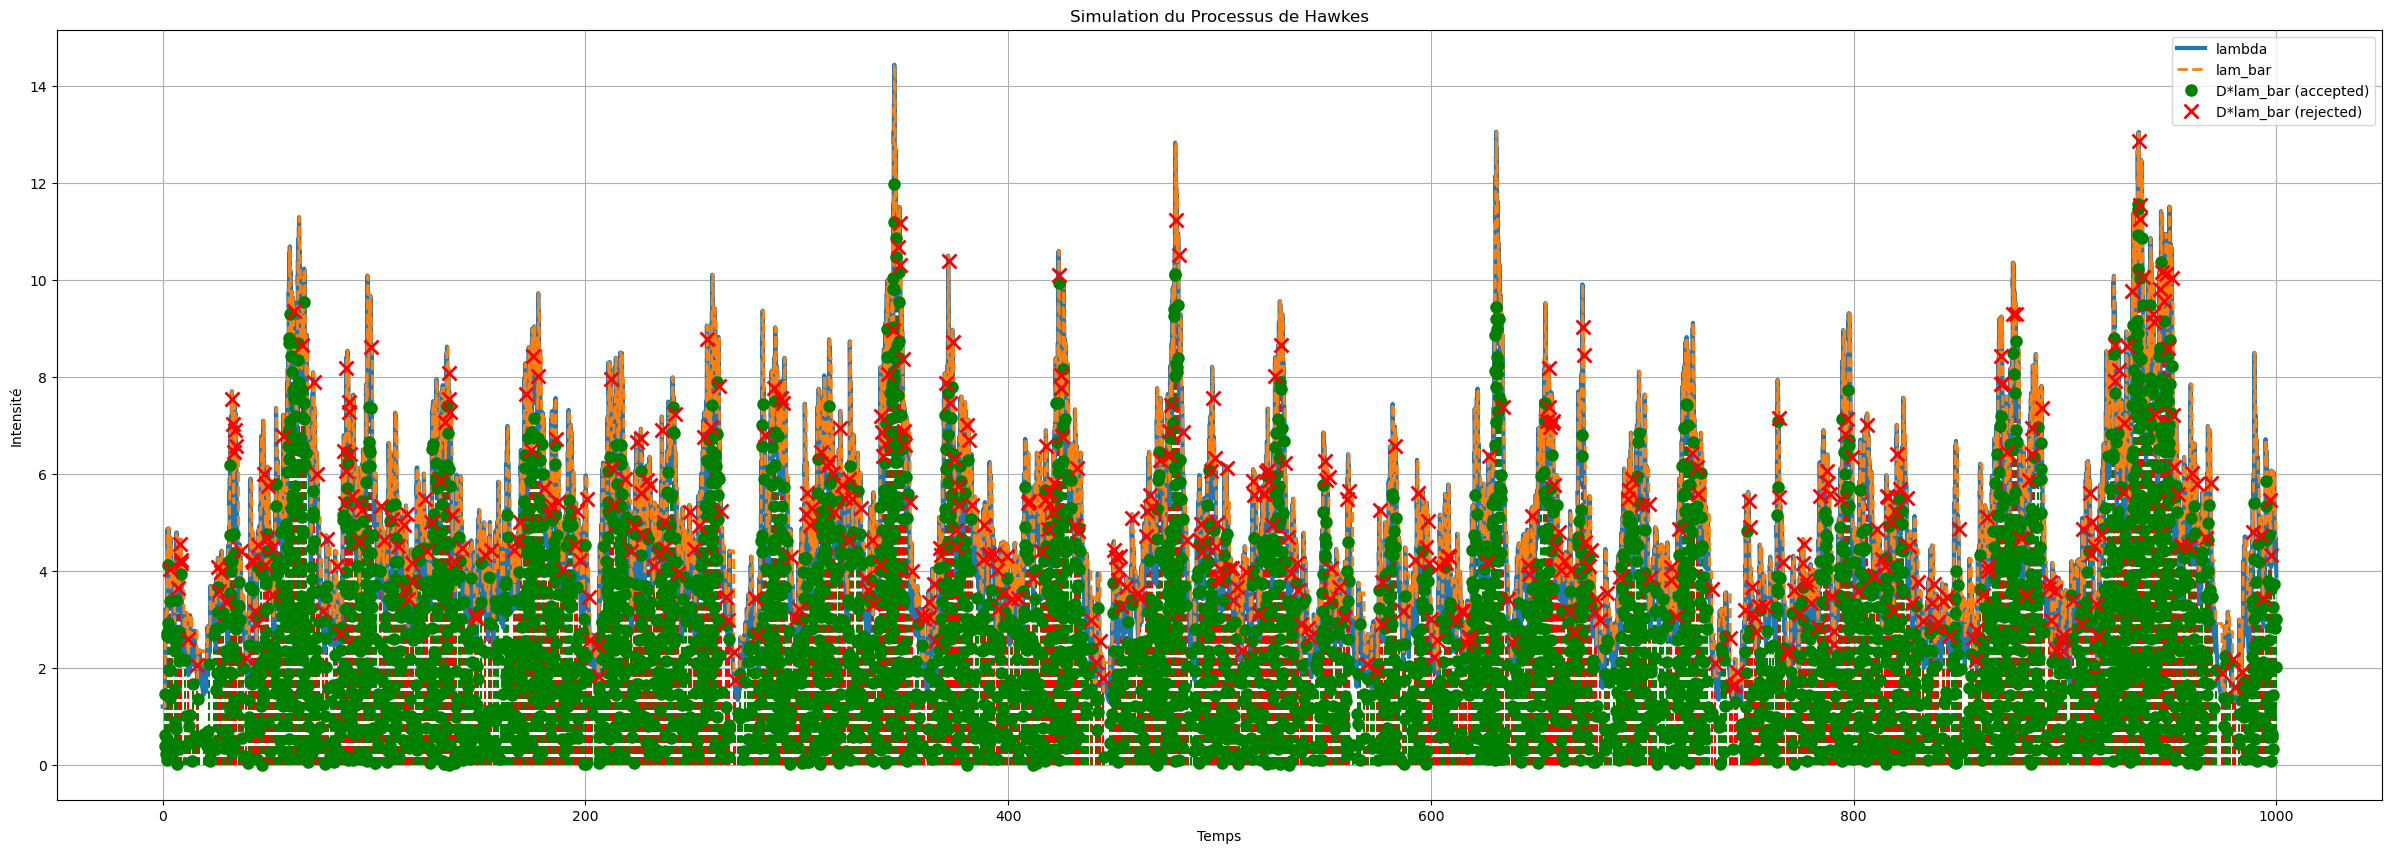

In [658]:
# Application:
mu = 1.2
alpha = 0.6
beta = 0.8
Tmax = 1000
TH,DH,TH_R,RH, D= Hawkes_Process(mu, alpha, beta, Tmax)

#Application de la fonction rate:
times=np.linspace(0,Tmax,Tmax*100)
l=[] ; sup_l = []; brk2 = []
j=0; count =0
for i in times:
    count +=1
    if j < len(TH)-1:
        if i < TH[0]:
            temp = mu
        elif i < TH[j]:
            temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:j]))))
        else :
            brk2.append(count-1)
            j=j+1
            temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:j]))))
        l.append(temp)
    else:
        temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:-1]))))
        l.append(temp)

        
#Affichage du lambda max
brk=[]
b=0
j=0
i=0

int_array = [int(x*100) for x in TH_R]
brk=brk2+int_array
brk=sorted(brk)

for j in range(len(brk)):
    while i < brk[j]:
        sup_l.append(max(l[b:brk[j]]))
        i+=1
    b=brk[j]
    j+=1
while i < len(l):
    sup_l.append(max(l[brk[-1]:len(l)-1]))
    i+=1


fig = plt.figure(figsize = (30, 10))


count=0
for i in TH:
    if count < len(DH):
        plt.plot([i, i], [0, DH[count]], 'g--')
        count+=1
    #plt.axvline(x=i, linestyle='--', color='green', linewidth=1)
count=0
for j in TH_R:
    if count < len(RH):
        plt.plot([j, j], [0, RH[count]], 'r--')
        count+=1
    #plt.axvline(x=j, linestyle='--', color='red', linewidth=1)

plt.plot(times, l,label="lambda", linewidth=3)
plt.plot(times, sup_l, linestyle='--', label="lam_bar",linewidth=2)

plt.plot(TH,DH, "o",color='green', markersize=8, label="D*lam_bar (accepted)")
plt.plot(TH_R,RH, "x",color='red', markersize=10, markeredgewidth=2, label="D*lam_bar (rejected)")
#TH2=TH+TH_R
#TH2=sorted(TH2)

#plt.plot(TH2, D,"^",color='blue', markersize=6, label="D ~ uniform(0,1)")
plt.xlabel('Temps')
plt.ylabel('Intensité')
plt.title('Simulation du Processus de Hawkes')
plt.legend()
plt.grid(True)
plt.show()

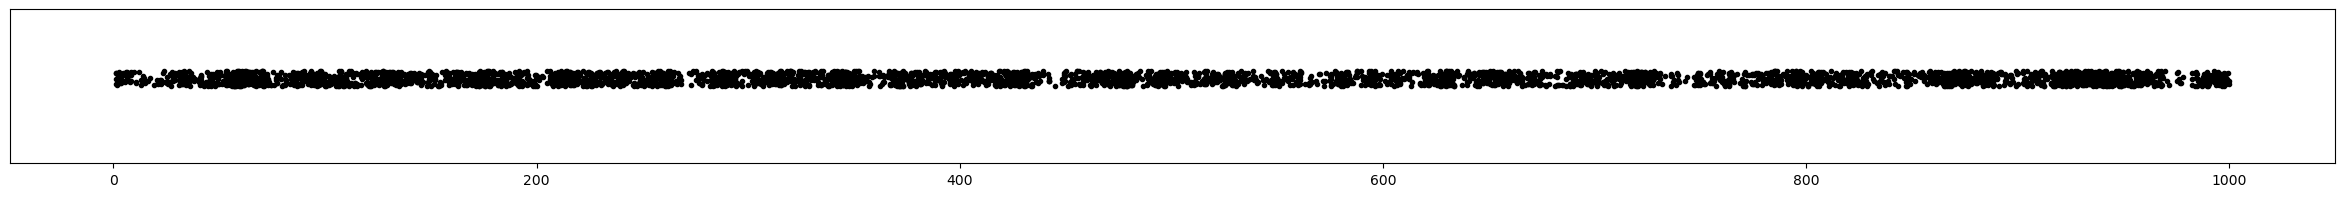

In [659]:
plt.figure(figsize=(30,2))
plt.ylim([-5, 5])
plt.yticks([])
_ = plt.plot(TH, np.random.rand(len(TH)), 'k.')

In [664]:
uv2 = UVHP()
#uv2.set_params(1.2,0.6,0.8)
uv2.fit(np.array(TH))
print(TH[-1])

999.9894016809443


In [665]:
# verify that the unconditional mean makes sense
mu, alpha, beta = uv2.get_params()

N_approx = mu * TH[-1] / (1 - alpha)

print(N_approx)
print(len(TH))
print("alpha:",alpha)
print("mu:",mu)
print("beta:",beta)

4650.125129008649
4634
alpha: 0.7335494123375967
mu: 1.2390417050873772
beta: 0.7561137290063089


**Interprétation :** On retrouve bien que le Hawkes tend vers les paramètres que nous lui avons donné pour une très grande échelle de temps. EN effet en regardant sur la fe,être [0,Tmax] avec Tmax =10 on ne retrouve que très rarement nos paramètres mais ici en prenant Tmax=1000, nous avons donc beaucoup plus de points accepté par l'algorithme de Thinning d'Ogata et on retrouve approximativement nos paramètres mu, alpha et beta de départ.

### Retour sur notre processus de comptage issu des données CAC40 - Modélisation

In [687]:
days,T,ind_1,ind_2,ind_seuil,TH_1an=compt(seuil=0.01,CAC40=CAC40_1an)
days,T,ind_1,ind_2,ind_seuil,TH_2an=compt(seuil=0.01,CAC40=CAC40_2an)
days,T,ind_1,ind_2,ind_seuil,TH_5an=compt(seuil=0.01,CAC40=CAC40_5an)

TH_CAC40=TH_5an

#### **Test de Kolmogorov Smirnoff Lilifors** - Modélisation par un Processus de Poisson Homogène
On veut désormais tester s'il existe un paramètre tel que le processus de comptage ci-dessus peut être assimilé à un processus de poisson homogène. Ainsi on teste si les inter-sauts quivent une loi exponentielle dont on ne connaît pas le paramètre. 

Ainsi on doit faire un test de Kolmogorov Smirnoff corrigé par Lilifors sur ces inter-sauts. Une p-valeur inférieure à 5% nous indiquerait qu'on rejette l'hypothèse disant que les inter-sauts sont exponentielles, donc on rejeterait le fait que notre processus est un processus de poisson homogène.

In [688]:
inter_saut=[]
for i in range(0,len(TH_CAC40)-1):
    inter_saut.append(TH_CAC40[i+1]-TH_CAC40[i])
    
#print(inter_saut)
#Test d'ajustement (Kolmogorov Smirnoff Lilifors)
ksstat, pvalue = sm.stats.diagnostic.lilliefors(inter_saut,"exp",'approx')
print("La stat de test est :",ksstat)
print("La p_value du test est ", pvalue)

alpha=0.05
if pvalue > alpha:
    result = 'Inter-Saut Exponentiel => Processus de Poisson Homogène'
else:
    result = 'Inter-Saut non-Exponentiel => Pas un Processus de Poisson Homogène'
print(f'Lilliefors: {result:>21s}')

La stat de test est : 0.1606878870993071
La p_value du test est  0.0009999999999998899
Lilliefors: Inter-Saut non-Exponentiel => Pas un Processus de Poisson Homogène


#### **Estimation des paramètres avec Hawkeslib** - Modélisation par un Proccesus de Hawkes

In [690]:
uv3 = UVHP()
uv3.fit(np.array(TH_CAC40))

-759.0239488138443

In [691]:
# verify that the unconditional mean makes sense
mu, alpha, beta = uv3.get_params()
#print(uv3.get_params())

N_approx = mu * TH_CAC40[-1] / (1 - alpha)

print(N_approx)
print(len(TH_CAC40))
print("mu:",mu)
print("alpha:",alpha)
print("beta:",beta)

273.06982886039776
271
mu: 0.05984708303022514
alpha: 0.6030939491922167
beta: 0.06245854821234395


mu: 0.05984708303022514
alpha: 0.6030939491922167
beta: 0.06245854821234395


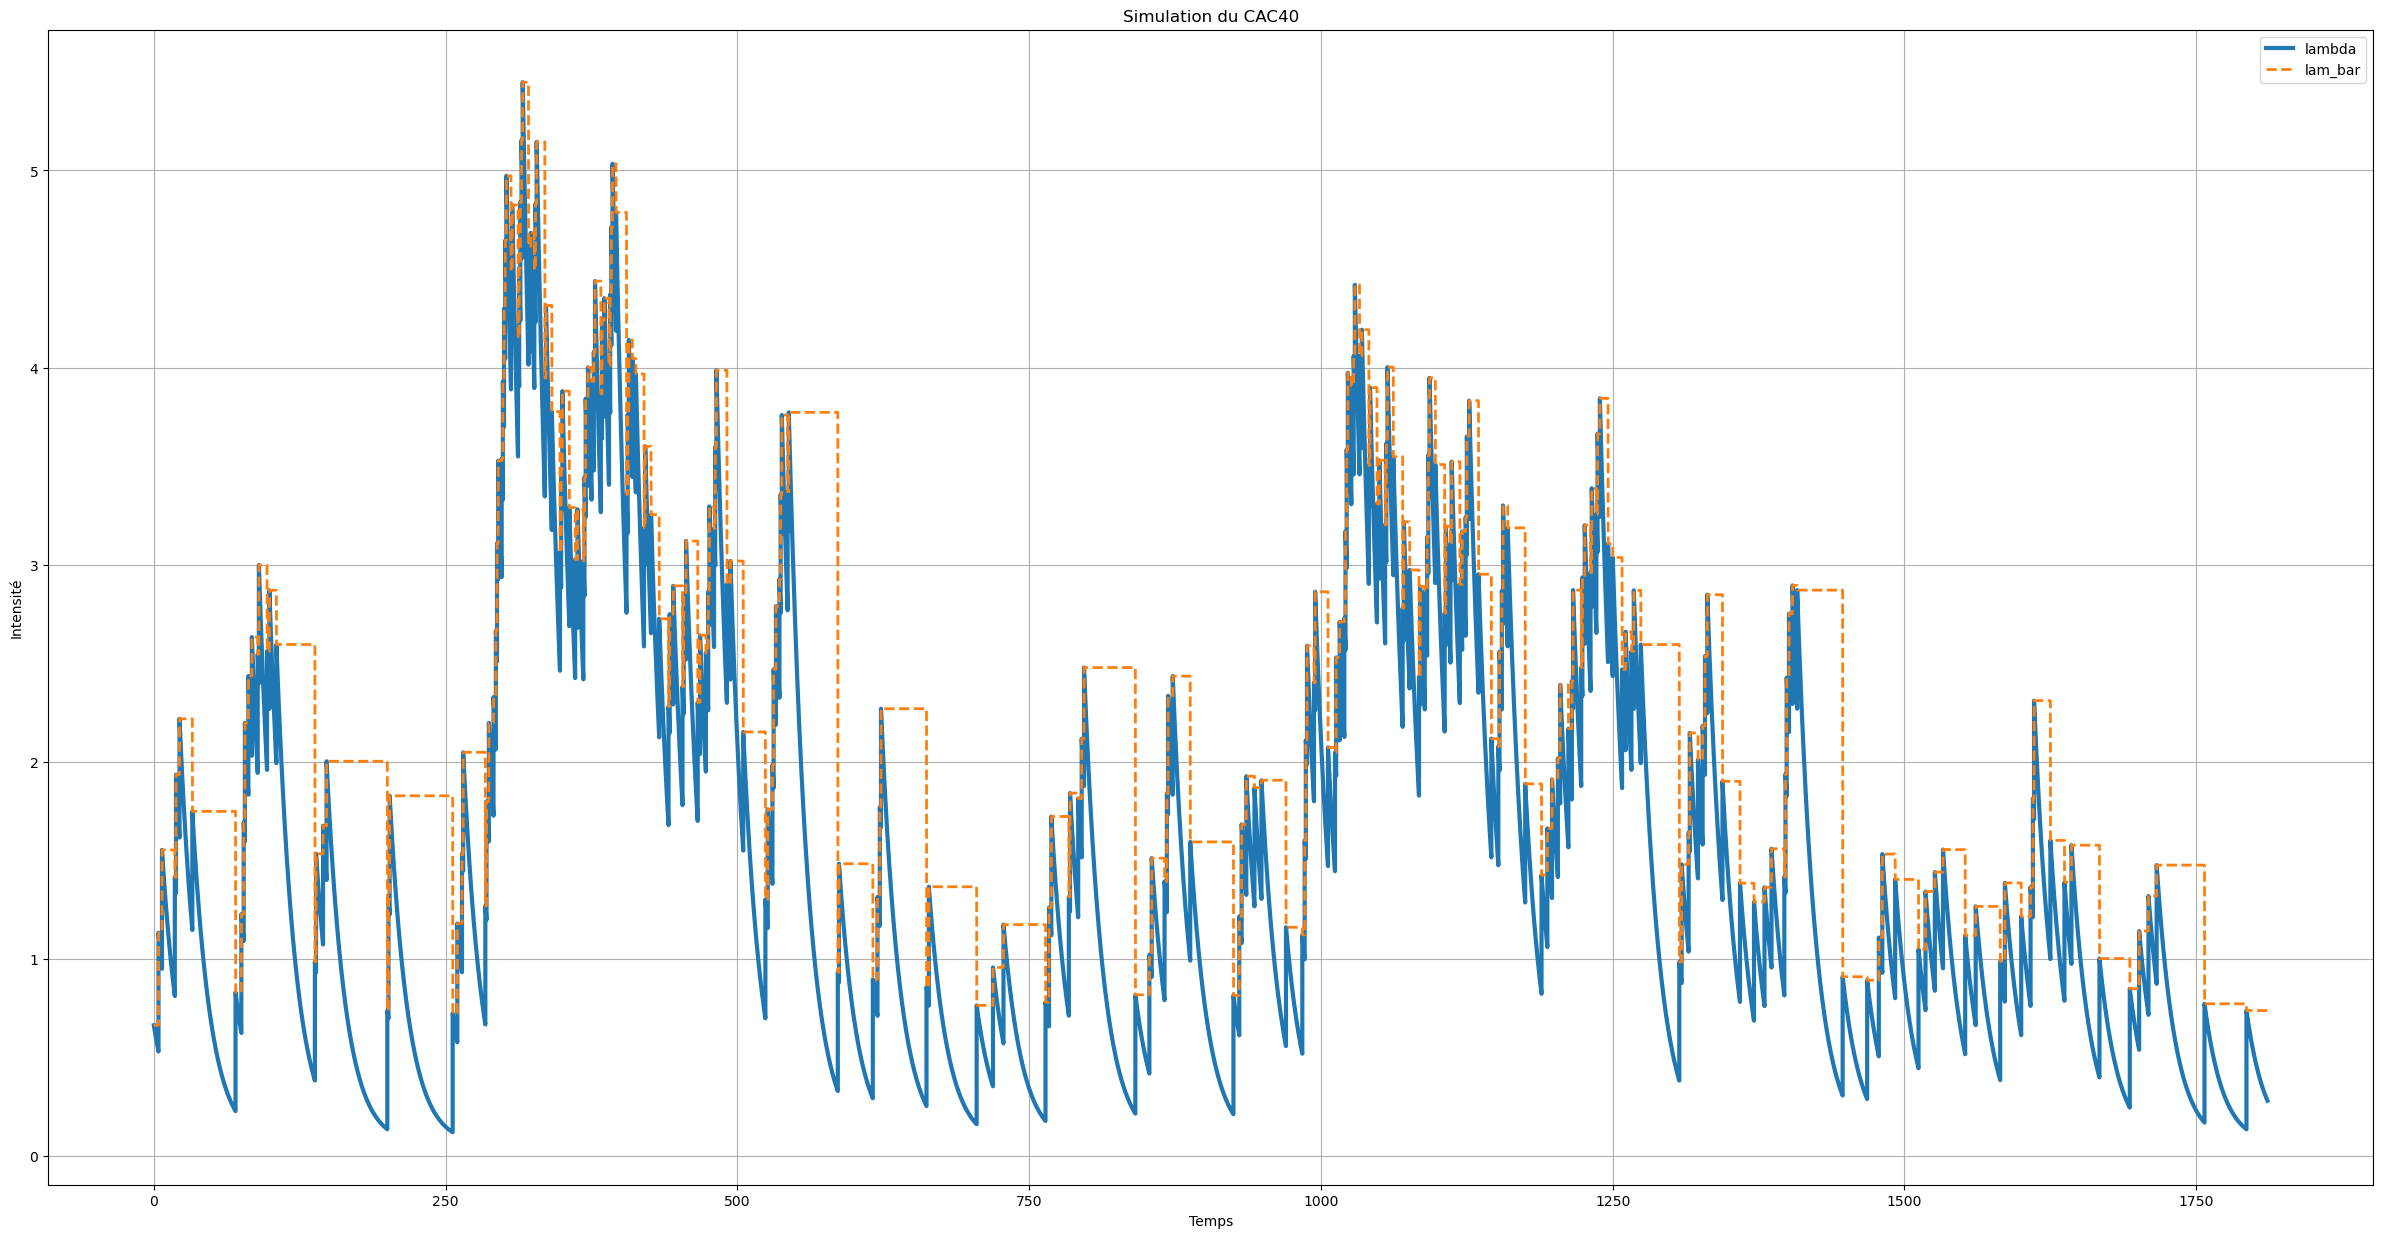

In [692]:
nb_points=int(TH_CAC40[-1])*100
print("mu:",mu)
print("alpha:",alpha)
print("beta:",beta)
times=np.linspace(TH_CAC40[0],TH_CAC40[-1],nb_points)
l=[] ; sup_l = []; brk2 = []
j=0; count =0
for i in times:
    count +=1
    if j < len(TH_CAC40)-1:
        if i < TH_CAC40[0]:
            temp = mu
        elif i < TH_CAC40[j]:
            temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH_CAC40[:j]))))
        else :
            brk2.append(count-1)
            j=j+1
            temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH_CAC40[:j]))))
        l.append(temp)
    else:
        temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH_CAC40[:-1]))))
        l.append(temp)


        
#Affichage du lambda max
brk=[]
b=0
j=0
i=0

brk=sorted(brk2)

for j in range(len(brk)):
    while i < brk[j]:
        sup_l.append(max(l[b:brk[j]]))
        i+=1
    b=brk[j]
    j+=1
while i < len(l):
    sup_l.append(max(l[brk[-1]:len(l)-1]))
    i+=1



fig = plt.figure(figsize = (30, 15))

plt.plot(times, l,label="lambda", linewidth=3)
plt.plot(times, sup_l, linestyle='--', label="lam_bar",linewidth=2)
plt.xlabel('Temps')
plt.ylabel('Intensité')
plt.title('Simulation du CAC40')
plt.legend()
plt.grid(True)
plt.show()

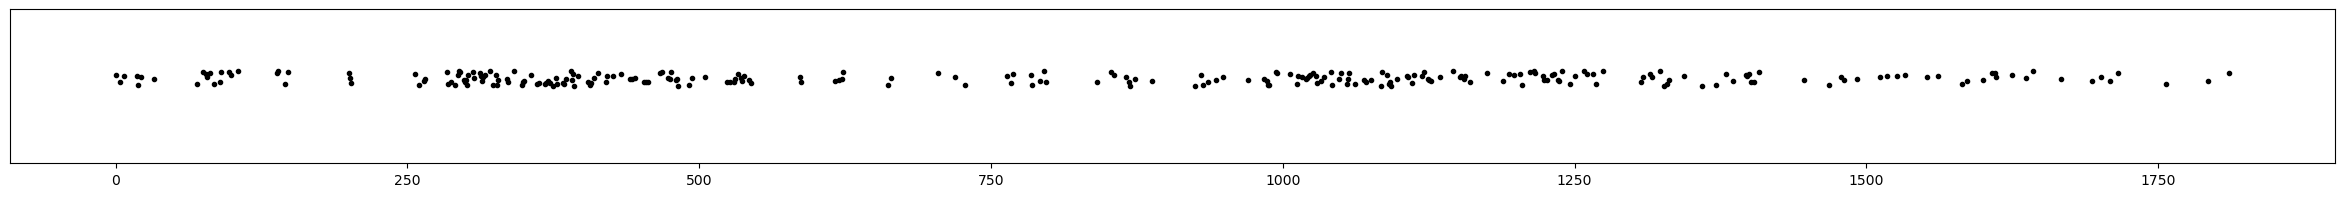

In [704]:
plt.figure(figsize=(30,2))
plt.ylim([-5, 5])
plt.yticks([])
_ = plt.plot(TH_CAC40, np.random.rand(len(TH_CAC40)), 'k.')

## ***BIBLIOGRAPHIE :***
- *Thinning Algorithms for Simulating Point Processes*, Yuanda Chen
- *Poisson processes and application to reliability theory and actuarial science*, Mélisande ALBERT
- *Cours sur les processus de poissons*, Université de Rennes, Jérémy Bettinger & Simon Viel
- *Processus de Poisson homogènes - Application à des données génomiques*, Mélisande ALBERT & Nicolas OGOREK
